In [84]:
from PBSHM_mdof.data.formatting import format_data
from PBSHM_mdof.models.utils import compute_auc, plot_control_chart, plot_control_chart_latent, compute_auc_df
from PBSHM_mdof.models.baseline import optht

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from PBSHM_mdof.models.utils import compute_auc
from sklearn.decomposition import PCA

df, labels, index_train, index_test, transformer = format_data(test_size=0.5)
system_name = (df['system_name'].unique()).tolist()
system_name.sort(key=lambda x:int(x.split('_')[-1]))

df_pca = df[['system_name','anomaly_level','state','latent_value','resonance_freq']]
df_pca['resonance_freq'] = df_pca['resonance_freq'].apply(lambda x: np.sort(x))

training_size = int(len(index_train)/len(system_name))

df_pca['anomaly_level'] = df['anomaly_level'].astype('float')
df_pca['type']= 'test'
df_pca.loc[index_train, 'type'] = 'train'
index_validation=df_pca.index[(df_pca['anomaly_level'] == 0) & (df_pca['type'] == 'test')]
df_pca.loc[index_validation,'type']='validation'

noise= 0.2
remove_mode =[0,7]
#adding noise to the data 
if noise != 0:
    df_pca['resonance_freq'] = df_pca['resonance_freq'].apply(lambda x: x + np.random.normal(0, noise, len(x)))
#removing modes 
df_pca['resonance_freq'] = df_pca['resonance_freq'].apply(lambda x: np.delete(x, remove_mode))

INFO:root:No NaN values in PSDs
INFO:root:Number of experiments in train set for system_9: 600
INFO:root:Number of experiments in train set for system_15: 600
INFO:root:Number of experiments in train set for system_18: 600
INFO:root:Number of experiments in train set for system_19: 600
INFO:root:Number of experiments in train set for system_17: 600
INFO:root:Number of experiments in train set for system_2: 600
INFO:root:Number of experiments in train set for system_8: 600
INFO:root:Number of experiments in train set for system_6: 600
INFO:root:Number of experiments in train set for system_1: 600
INFO:root:Number of experiments in train set for system_11: 600
INFO:root:Number of experiments in train set for system_12: 600
INFO:root:Number of experiments in train set for system_7: 600
INFO:root:Number of experiments in train set for system_16: 600
INFO:root:Number of experiments in train set for system_13: 600
INFO:root:Number of experiments in train set for system_4: 600
INFO:root:Numbe

In [85]:
df_pca

,system_name,anomaly_level,state,latent_value,resonance_freq,type
0,system_0,0.01,anomalous,26.871220,"[22.564078489472113, 44.43950095189006, 63.476...",test
1,system_1,0.01,anomalous,26.871220,"[21.601149672524002, 43.529349885344736, 63.69...",test
2,system_10,0.01,anomalous,26.871220,"[22.70898982287457, 45.603353989575545, 65.676...",test
3,system_11,0.01,anomalous,26.871220,"[22.958610737024888, 45.44807151082253, 66.042...",test
4,system_12,0.01,anomalous,26.871220,"[22.449190815052493, 44.5365542228307, 64.7851...",test
...,...,...,...,...,...,...
51995,system_5,0.00,healthy,80.960747,"[20.61760444137481, 42.49118298131701, 63.4359...",train
51996,system_6,0.00,healthy,80.960747,"[21.156932637945253, 42.423608713155915, 63.71...",train
51997,system_7,0.00,healthy,80.960747,"[20.70937259263662, 43.51511211498522, 65.0765...",validation
51998,system_8,0.00,healthy,80.960747,"[21.330925009926982, 43.41180006619006, 62.968...",validation


In [ ]:
embe

In [86]:
def compute_residual(pca,data):
    data = data.reshape(1,-1)
    residual = data - pca.inverse_transform(pca.transform(data))
    residual = float(np.sum(np.square(residual), axis=1))
    return -residual

In [87]:
from PBSHM_mdof.models.baseline import optht
def find_best_k(training_res):
    U, s, Vh = np.linalg.svd(training_res, full_matrices=False)
    k = optht.optht(training_res, sv=s, sigma=None)
    k= 3 # hard coded for now using the elbow method for consistency with the paper check scree plot below
    return k

In [88]:
for sys in system_name:
    df_sys = df_pca[df_pca['system_name'] == sys]
    idx_sys = df_sys.index
    idx_train = df_sys.index[df_sys['type']=='train']
    res_train = np.stack(df_sys.loc[idx_train,'resonance_freq'].values)
    mean = np.mean(res_train, axis=0)
    std = np.std(res_train, axis=0)
    df_pca.loc[idx_sys,'resonance_freq'] = df_pca.loc[idx_sys,'resonance_freq'].apply(lambda x: (x-mean)/std)


In [89]:

for sys in system_name:
    df_sys = df_pca[df_pca['system_name'] == sys]
    idx_sys = df_sys.index
    idx_train = df_sys.index[df_sys['type']=='train']
    res_train = np.stack(df_sys.loc[idx_train,'resonance_freq'].values)
    # fit PCA
    pca = PCA(n_components=3)
    pca.fit(res_train)
    # compute residual
    df_pca.loc[idx_sys,'residual'] = df_pca.loc[idx_sys,'resonance_freq'].apply(lambda x: compute_residual(pca,x))
    del pca

In [90]:
compute_auc_df(df_pca,col_name='residual').mean(axis=1)

auc_0.0     0.499831
auc_0.01    0.505402
auc_0.03    0.540235
auc_0.05    0.591796
auc_0.07    0.664651
auc_0.09    0.745295
auc_0.11    0.802312
auc_0.13    0.861869
dtype: float64

(<Figure size 1000x500 with 1 Axes>,
 <AxesSubplot: title={'center': 'system_1'}, xlabel='index', ylabel='residual'>)

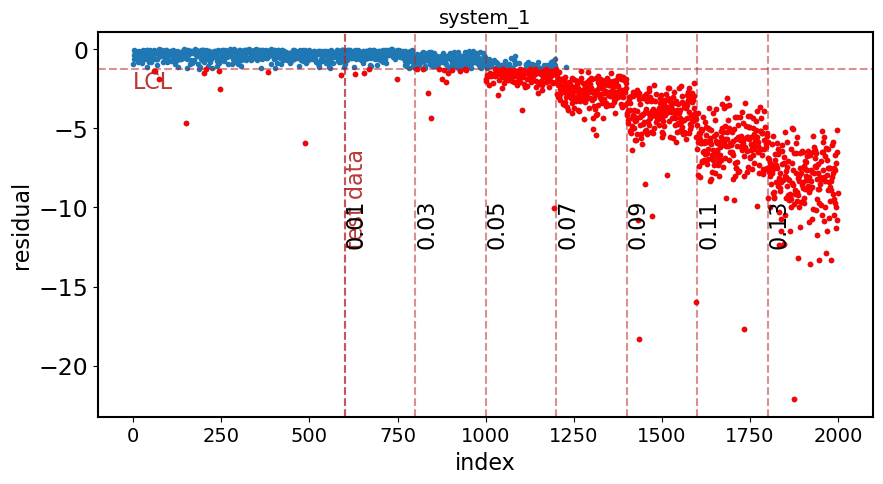

In [83]:
plot_control_chart(df_pca,system_id='system_1',column='residual')

The recommended number of principal components to retain is 3.


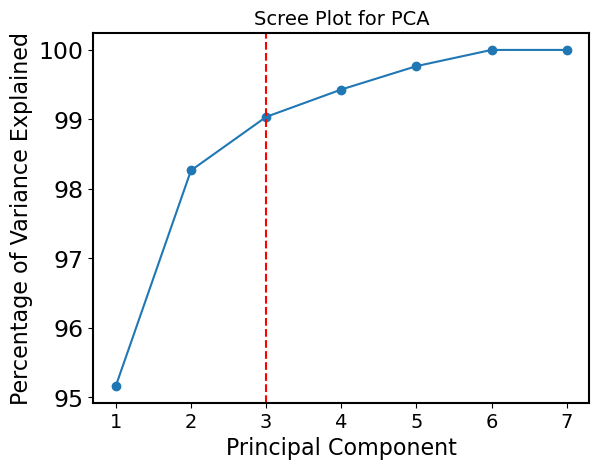

In [299]:
# scree plot of pca 

from sklearn.decomposition import PCA
sys = 'system_1' 
data_system = df_pca[df_pca['system_name']==sys]
pca = PCA(n_components=7)
data_system = data_system[data_system['type']=='train']
res_train = np.stack(data_system['resonance_freq'],axis=1)
pca.fit(res_train)# Get the explained variance ratio from PCA
explained_var = pca.explained_variance_ratio_

# Calculate the cumulative sum of explained variance ratios
cumulative_var = np.cumsum(explained_var)

# Calculate the percentage of variance explained by each component
variance_pct = cumulative_var * 100

# Plot the scree plot
fig, ax = plt.subplots()
ax.plot(range(1, len(variance_pct) + 1), variance_pct, marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Percentage of Variance Explained')
ax.set_title('Scree Plot for PCA')

# Determine the number of principal components to consider using the elbow method
diff = np.abs(np.diff(np.diff(variance_pct)))[0:]
elbow_index = np.argmin(diff) + 1
ax.axvline(x=elbow_index, linestyle='--', color='red')

# Print the recommended number of principal components
print(f"The recommended number of principal components to retain is {elbow_index}.")

plt.show()


INFO:PBSHM_mdof.models.baseline.optht:Sigma unknown.
INFO:PBSHM_mdof.models.baseline.optht:Approximated `w(beta)` value: 1.451104917037037
INFO:PBSHM_mdof.models.baseline.optht:`w(beta)` value: 1.4407471445826059
INFO:PBSHM_mdof.models.baseline.optht:Cutoff value: 2.063709679036337
INFO:PBSHM_mdof.models.baseline.optht:Target rank: 3


3

In [154]:
def prepare_data_pca(df, system_name,noise):
    data_system = df[df['system_name'] == system_name]
    data_system = data_system.sort_values(by="type", ascending=True, key=lambda x: x.map({"train": 0, "validation": 1, "test": 2}))
    data_system.sort_values(by='anomaly_level',ascending=True, inplace=True)
    print(data_system)
    anomaly_level=data_system[data_system['anomaly_level'].astype(float).diff()!=0]['anomaly_level'].to_dict()

    all_res = np.stack(data_system['resonance_freq'].values)
    indexs = data_system.index
    all_res = all_res[:,1:]
    all_res = all_res + np.random.normal(0, noise, all_res.shape)
    training_res = all_res[0:training_size,:]

    std = np.std(training_res, axis=0)
    mean = np.mean(training_res, axis=0)
    all_res = (all_res - mean)/std
    training_res = (training_res - mean)/std
    return training_res, all_res, anomaly_level, indexs

In [156]:
def train_pca(training_res,all_res,k):
    pca = PCA(n_components=k)
    pca.fit(training_res)
    residual = all_res - pca.inverse_transform(pca.transform(all_res))
    residual = np.sum(np.square(residual), axis=1)
    return residual

def compute_auc_df(df,col_name='confidence'):
    system_name = df['system_name'].unique().tolist()
    system_name.sort(key=lambda x: int(x.split('_')[-1]))
    anomaly_level = np.sort(df['anomaly_level'].unique())
    auc_df = pd.DataFrame(columns=system_name)
    for system_id in system_name:
        healthy_training_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'train')]
        healthy_testing_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'validation')]
      
        
        for al in anomaly_level:
            if al == 0:
                assert len(healthy_training_data) == len(healthy_testing_data)
                auc = compute_auc(healthy_training_data, healthy_testing_data)
            else:
                anomaly_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'test') & (df['anomaly_level'] == al)]
                healthy_testing_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'validation')].iloc[-len(anomaly_data):]
                assert len(anomaly_data) == len(healthy_testing_data)
                auc = compute_auc(healthy_testing_data, anomaly_data)
            auc_df.loc[f'auc_{al}', system_id] = auc
    return auc_df

In [157]:
df_pca['residual'] = np.nan

In [158]:
# feat a pca for each system using defaultdict to save them
from collections import defaultdict
pca_dict = defaultdict(PCA)
for sys in system_name:
    training_res, all_res, anomaly_level,indexs=prepare_data_pca(df_pca, sys,noise)
    k = find_best_k(training_res)
    residual = train_pca(training_res,all_res,k)
    
    df_pca.iloc[indexs]=residual
    pca_dict[sys].fit(training_res)
    


INFO:PBSHM_mdof.models.baseline.optht:Sigma unknown.
INFO:PBSHM_mdof.models.baseline.optht:Approximated `w(beta)` value: 1.44810556
INFO:PBSHM_mdof.models.baseline.optht:`w(beta)` value: 1.4370270233437419
INFO:PBSHM_mdof.models.baseline.optht:Cutoff value: 3.140600835584225
INFO:PBSHM_mdof.models.baseline.optht:Target rank: 3


      system_name  anomaly_level      state  latent_value  \
29080    system_0           0.00    healthy     83.615875   
2360     system_0           0.00    healthy     58.424683   
2340     system_0           0.00    healthy      8.042460   
26040    system_0           0.00    healthy     66.404198   
31660    system_0           0.00    healthy     70.035118   
...           ...            ...        ...           ...   
7120     system_0           0.13  anomalous     59.499660   
12120    system_0           0.13  anomalous     53.472878   
12280    system_0           0.13  anomalous     74.248619   
26000    system_0           0.13  anomalous     49.139069   
10520    system_0           0.13  anomalous     41.017071   

                                          resonance_freq        type  residual  
29080  [-1.9860160405870233, -2.0495825008879707, -1....       train       NaN  
2360   [-0.1974478257989505, -0.17341664690307781, -0...  validation       NaN  
2340   [1.20529612551606

ValueError: Must have equal len keys and value when setting with an iterable

In [159]:
def compute_auc_df(df,col_name='confidence'):
    system_name = df['system_name'].unique().tolist()
    system_name.sort(key=lambda x: int(x.split('_')[-1]))
    anomaly_level = np.sort(df['anomaly_level'].unique())
    auc_df = pd.DataFrame(columns=system_name)
    for system_id in system_name:
        healthy_training_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'train')]
        healthy_testing_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'validation')]
      
        
        for al in anomaly_level:
            if al == 0:
                assert len(healthy_training_data) == len(healthy_testing_data)
                auc = compute_auc(healthy_training_data, healthy_testing_data)
            else:
                anomaly_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'test') & (df['anomaly_level'] == al)]
                healthy_testing_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'validation')].iloc[-len(anomaly_data):]
                assert len(anomaly_data) == len(healthy_testing_data)
                auc = compute_auc(healthy_testing_data, anomaly_data)
            auc_df.loc[f'auc_{al}', system_id] = auc
    return auc_df

ValueError: Input contains NaN.

In [151]:
df_pca

,system_name,anomaly_level,state,latent_value,resonance_freq,type,residual
0,system_0,0.01,anomalous,26.871220,"[0.9021088952057335, 0.8424425340126693, 1.064...",test,[0.017944723650693564]
1,system_1,0.01,anomalous,26.871220,"[0.9263606647791403, 0.9133565249492163, 0.982...",test,[0.0389806938104686]
2,system_10,0.01,anomalous,26.871220,"[0.9049276438200209, 0.8317563868325561, 0.991...",test,[0.027509877891167198]
3,system_11,0.01,anomalous,26.871220,"[0.9061874727315508, 0.9070255128016013, 0.943...",test,[0.019067236050450583]
4,system_12,0.01,anomalous,26.871220,"[0.9512310504039474, 0.7720666959524964, 1.088...",test,[0.021768189356345065]
...,...,...,...,...,...,...,...
51995,system_5,0.00,healthy,80.960747,"[-1.735602019931616, -1.793537192719271, -1.79...",train,[0.0017491143732332932]
51996,system_6,0.00,healthy,80.960747,"[-1.5694939734661948, -1.6122915192704692, -1....",train,[0.002266496197419553]
51997,system_7,0.00,healthy,80.960747,"[-1.6596061876034203, -1.7250453250869966, -1....",validation,[0.002163530286514455]
51998,system_8,0.00,healthy,80.960747,"[-1.6537356911086625, -1.7240014829631025, -1....",validation,[0.0003606072293865127]


ValueError: ('Lengths must match to compare', (2000,), (1,))

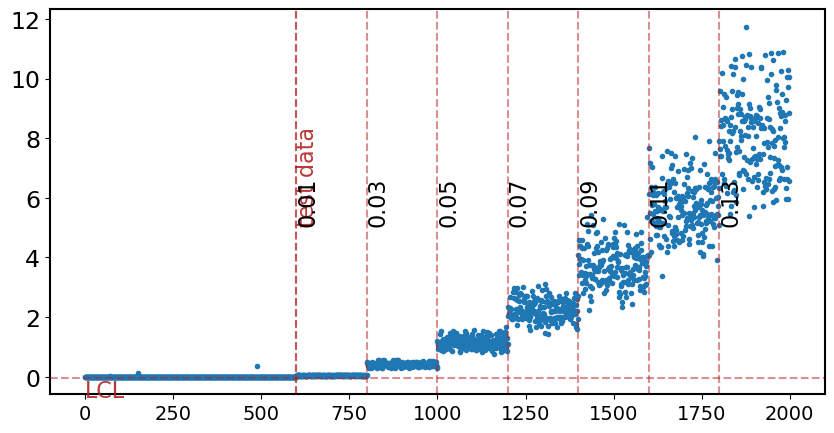